Cargo paquetes necesarios

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import math
from scipy.signal import find_peaks
import random

Defino funciones a utilizar. No modificar

In [ ]:
def cargar_motionDAQ(nombre):
    data = pd.read_csv(nombre, skiprows=4, delimiter="\t", decimal=",", header=None)
    t = data[0].values
    v = data[1].values
    return t, v

# y = datos. f = ajuste. sd = errores del ajuste. k = cantidad de parametros
def reduced_chi_sq(y, f, sd, k):
  # https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic
  return np.sum(((y-f)/sd)**2) / (len(y)-k)

def r_sq(y, f):
  # https://en.wikipedia.org/wiki/Coefficient_of_determination
  rss = np.sum((y-f)**2)
  tss = np.sum((y-np.mean(y))**2)
  return 1 - rss/tss

def Residuos(y, f):
  residuos = y-f
  return residuos

Genero datos de ejemplo. No es necesario correr esta celda

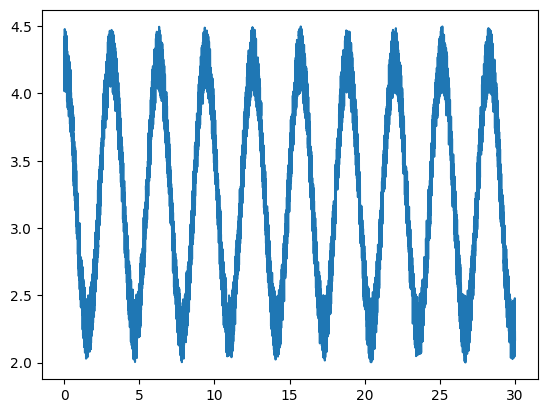

In [ ]:
t = np.arange(0,30,0.005)

A = 2
gamma = 0.05
W = 1/0.5
F0 = 3


v = A*np.exp(-gamma*t)*np.cos(W*t)+F0
#v = np.cos(W*t)+F0
for i in range(len(v)):
  v[i] = v[i]+random.random()*.5
plt.plot(t,v)
plt.show()

In [ ]:
t, v=cargar_motionDAQ("/content/amortiguado1.csv") #cargo los datos

FileNotFoundError: ignored

Hallar picos. Cambiando el parametro 'dist' podemos cambiar la distancia entre picos

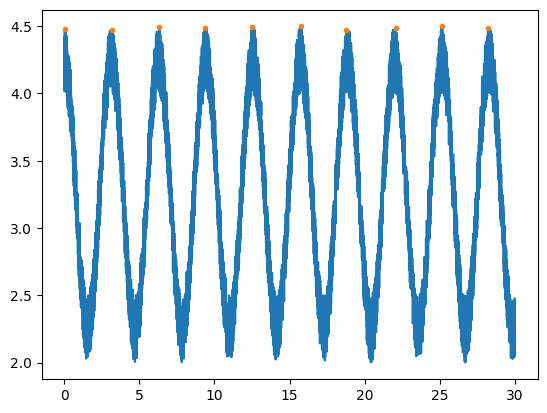

In [ ]:
dist = 500 #distancia entre picos
altura = 3 # altura minima de los picos
pos_picos,_ = find_peaks(v,distance=dist, height = altura) #extra posiciones de los picos
tiempo_picos = t[pos_picos] #evaluo las posiciones en los tiempos
fuerza_picos = v[pos_picos] #evaluo las posiciones en las fuerzas
plt.plot(t,v)
plt.plot(tiempo_picos,fuerza_picos,'.')
plt.show()

Si estoy analizando el movimiento armonco simple, promedio los picos. Si estoy en el caso armortiguado, sigo con los ajustes.

In [ ]:
periodo = np.mean(np.diff(tiempo_picos))
frecuencia = 2*np.pi/periodo
print(f"Periodo = {periodo:.4f}, W0 = {frecuencia:.4f}")

Periodo = 3.1317, W0 = 2.0063



## **Ajuste Exponencial**

Una vez extraidos los picos, los ploteamos con sus errores: y realizamos el ajuste no lineal





In [ ]:
FrecMuestreo = 500 # poner la frecuencia de muestreo

x = tiempo_picos
y = fuerza_picos

dx = np.repeat(1/FrecMuestreo,len(tiempo_picos)) #creo un array de errores iguales
#dF = np.array([0.1,0.1,0.1,0.1,0.1,0.1])
dy = np.repeat(0.05,len(fuerza_picos)) # creo otro array de errores iguales. para pensar que errores van aca


def exponencial(x,A,g,F0): #defino ajuste exponencial
  return A * np.exp(-g * x) + F0

#valores iniciales para el ajuste no lineal
A0 = 1
g0 = 1
F00 = 1
InitialGuess = [A0,g0,F00]

popt, pcov = curve_fit(exponencial, x, y, sigma=dy,
                       absolute_sigma=True,p0 = InitialGuess)#funcion de ajuste
[A,g,F0] = popt #parametros ajustados
er_A,er_g,er_F0 = np.sqrt(np.diag(pcov)) #errores de parametros ajustados

print('A = ', A, '+/-', er_A)
print('gamma = ', g, '+/-', er_g)
print('F0 = ', F0, '+/-', er_F0)

A =  1.9907130123418668 +/- 0.1707348380892977
gamma =  0.049990883413369144 +/- 0.008835143801597617
F0 =  3.488649333886195 +/- 0.18804633284089917


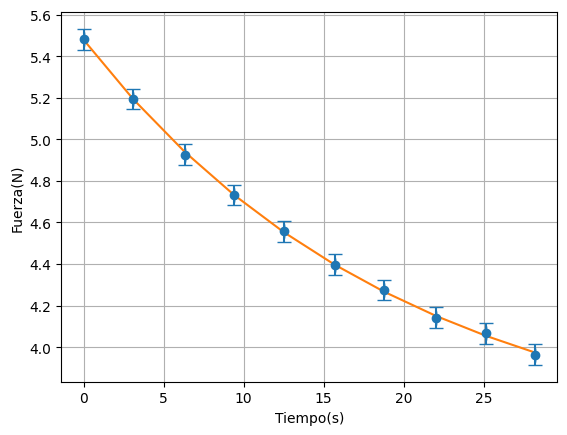

In [ ]:
#plt.plot(tiempo_picos,fuerza_picos,'.')
ajuste = exponencial(x,A,g,F0) #evaluo la exponencial en los datos hallados

plt.errorbar(x,y, xerr=dx, yerr=dy, fmt='o', capsize=5)
plt.plot(x,ajuste)
plt.xlabel('Tiempo(s)')
plt.ylabel('Fuerza(N)')
plt.grid(True)
plt.show()




R cuadrado =  0.9997347263244335
Chi cuadrado =  0.03476313668053994


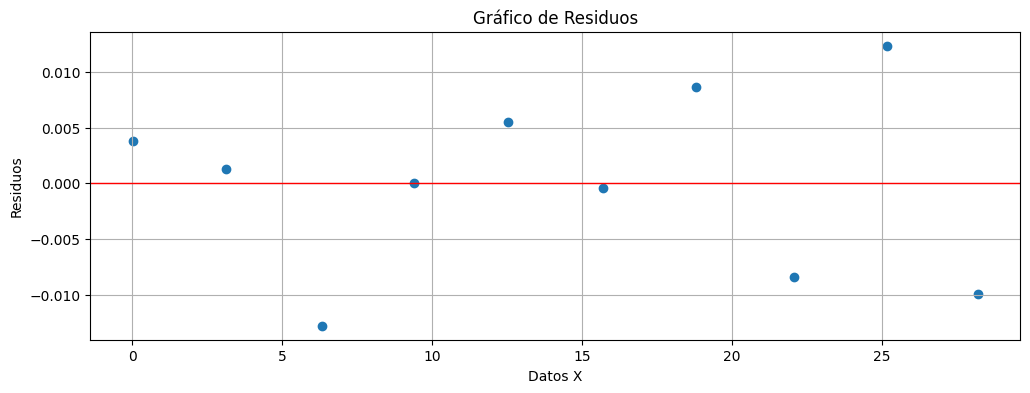

In [ ]:

r2 = r_sq(y,ajuste)
chi2 = reduced_chi_sq(y,ajuste,dy,3)
residuos = Residuos(y,ajuste)

print('R cuadrado = ', r2)
print('Chi cuadrado = ',chi2)

plt.figure(figsize=(12, 4))
plt.scatter(x, residuos, marker='o')
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)
plt.xlabel('Datos X')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(True)

## **Ajuste Lineal**

Una vez extraidos, linealizamos y realizamos el ajuste lineal. RECORDAR PROPAGAR ERRORES

In [ ]:
y = np.log(fuerza_picos-F0) #uso el F0 del ajuste anterior para el siguiente

x = tiempo_picos
dx = np.repeat(1/FrecMuestreo,len(tiempo_picos))
#dF = np.array([0.1,0.1,0.1,0.1,0.1,0.1])
dy = np.repeat(0.05,len(fuerza_picos)) #piensenlo


def lineal(X,m,b):
  return m*X + b

popt, pcov = curve_fit(lineal, x, y, sigma=dy,
                       absolute_sigma=True,)
[m,b] = popt
er_m,er_b = np.sqrt(np.diag(pcov))

print('Pendiente = ', m, '+/-', er_m)
print('Ordenada = ', b, '+/-', er_b)

Pendiente =  -0.050088518759303424 +/- 0.0017535999420402446
Ordenada =  0.6896312628821774 +/- 0.0293940626736774


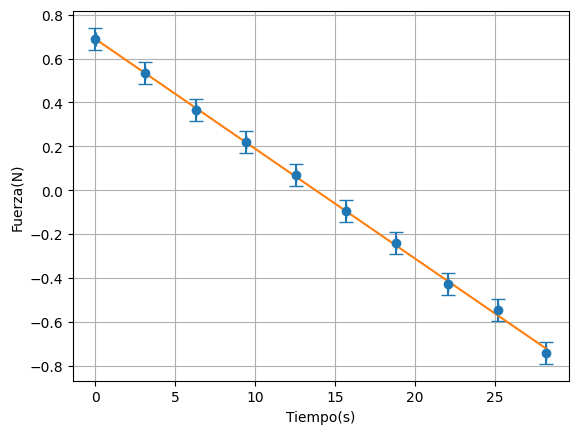

In [ ]:
#plt.plot(tiempo_picos,fuerza_picos,'.')
ajuste = lineal(x,m,b)

plt.errorbar(x,y, xerr=dx, yerr=dy, fmt='o', capsize=5)
plt.plot(x,ajuste)
plt.xlabel('Tiempo(s)')
plt.ylabel('Fuerza(N)')
plt.grid(True)
plt.show()

R cuadrado =  0.9993703211994018
Chi cuadrado =  0.06425663396450626


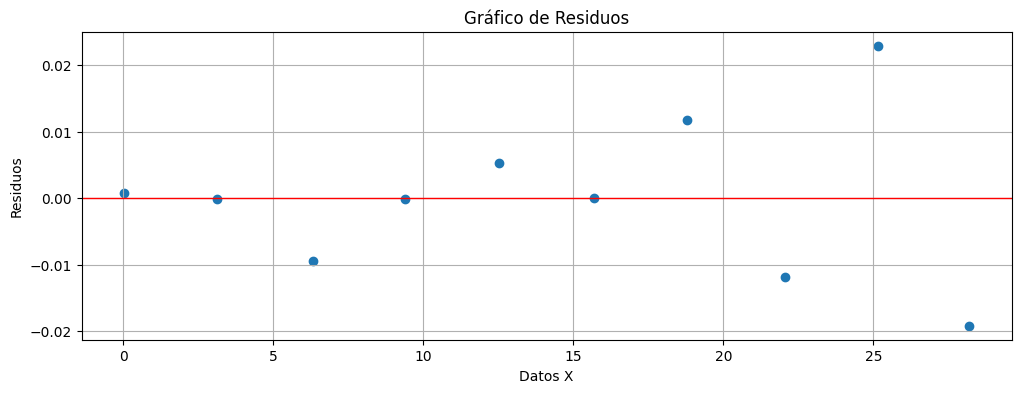

In [ ]:
r2 = r_sq(y,ajuste)
chi2 = reduced_chi_sq(y,ajuste,dy,2)
residuos = Residuos(y,ajuste)

print('R cuadrado = ', r2)
print('Chi cuadrado = ',chi2)

plt.figure(figsize=(12, 4))
plt.scatter(tiempo_picos, residuos, marker='o')
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)
plt.xlabel('Datos X')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(True)

## **Ajuste Completo**

Ajusto toda la serie

In [ ]:

x = t
y = v

def completo(x,A,g,F0,W,phi):
  return A * np.exp(-g * x)*np.cos(W*x+phi) + F0

#valores iniciales para el ajuste no lineal
A0 = 1
g0 = 0.5
F00 = 1
W0 = 1
phi0 = 1
InitialGuess = [A0,g0,F00,W0,phi0]

#agrego limites a los parametros a traves de bounds
# en el primer parentesis pongo los limites inferiores, en el segundo los superiores
popt, pcov = curve_fit(completo, x, y,p0 = InitialGuess,
                       bounds=((-np.inf,-np.inf,-np.inf,-np.inf,0),(np.inf,np.inf,np.inf,np.inf,2*np.pi)))

[A,g,F0,W,phi] = popt
er_A,er_g,er_F0,er_W,er_phi = np.sqrt(np.diag(pcov))

print('A = ', A, '+/-', er_A)
print('gamma = ', g, '+/-', er_g)
print('F0 = ', F0, '+/-', er_F0)
print('W = ', W, '+/-', er_W)
print('phi = ', phi, '+/-', er_phi)

A =  1.9997696403446616 +/- 0.007160139678988659
gamma =  0.049848250855466174 +/- 0.00032362911655271033
F0 =  3.2479681780483354 +/- 0.0018430715150050928
W =  1.9999676443818462 +/- 0.0003270758576348198
phi =  9.710500302857411e-17 +/- 0.003608321172310526


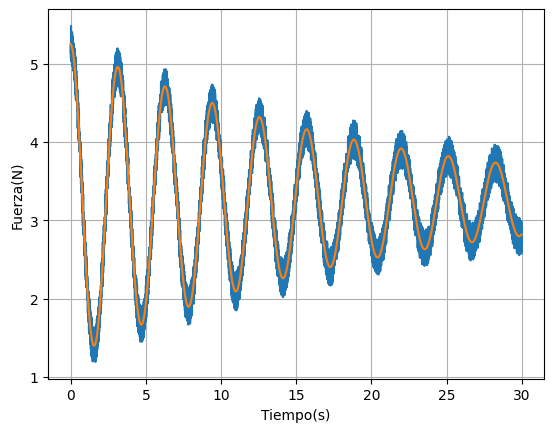

In [ ]:
ajuste = completo(x,A,g,F0,W,phi) #evaluo la exponencial en los datos hallados

plt.plot(x,y)
plt.plot(x,ajuste)
plt.xlabel('Tiempo(s)')
plt.ylabel('Fuerza(N)')
plt.grid(True)
plt.show()




R cuadrado =  0.9690775160273255


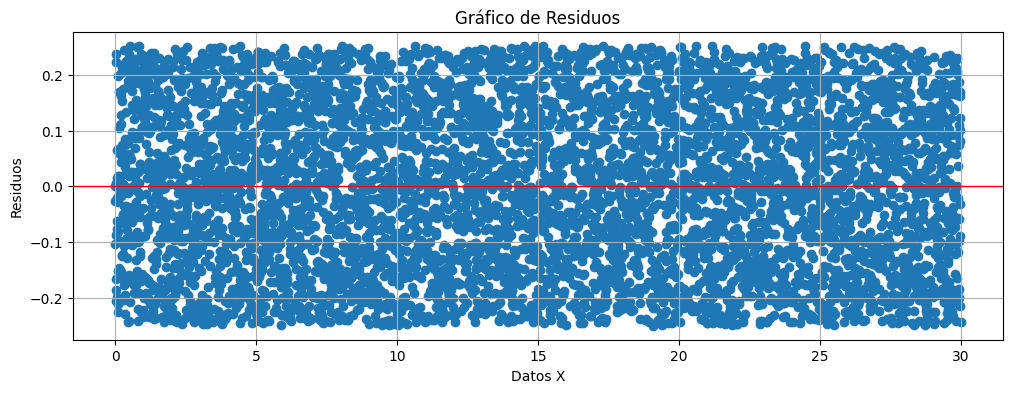

In [ ]:

r2 = r_sq(y,ajuste)
residuos = Residuos(y,ajuste)

print('R cuadrado = ', r2)

plt.figure(figsize=(12, 4))
plt.scatter(x, residuos, marker='o')
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)
plt.xlabel('Datos X')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(True)